In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from importlib import reload
import pickle

import RNDPricer as rnd
reload(rnd)

<module 'RNDPricer' from '/Users/adammoszczynski/Desktop/research/Kalshi-Arb/RNDPricer.py'>

In [82]:
df = pd.read_csv('spx_w/eoy_chains.csv')
df.sort_values(['quote', 'strike'], inplace=True)
days = df['quote'].unique().tolist()

In [83]:
with open("kalshi_data.pkl", "rb") as f:
    kalshi_data = pickle.load(f)

### Strategy
to be adjusted

In [105]:
fees = 0.01
year = 2024
max_K_distance = 250


tickers = kalshi_data[year]["tickers"]
price_df = kalshi_data[year]["price"]
bid_df = kalshi_data[year]["bid"]
ask_df = kalshi_data[year]["ask"]

days = df.loc[(df['quote'] >= str(year)+"-01-01") & (df['quote'] <= str(year)+"-12-31")]['quote'].unique().tolist()

positions = []

for day in days:
    # getting option data
    day_df = df[df['quote']==day].copy()
    if day_df.empty:
        print(f"Option data empty on {day}")
        continue
    
    # initializing RND
    try:
        rndp = rnd.RNDPricer(day_df)
    except ValueError:
        print(f"RND error on {day}")
        continue
    
    # check kalshi bucket data
    if day not in bid_df.index or day not in ask_df.index:
        print(f"Kalshi data missing {day}")
        continue
    
    day_bids = bid_df.loc[day]
    day_asks = ask_df.loc[day]
    tradable_buckets = [col for col in day_bids.index if not (pd.isnull(day_bids[col]) or pd.isnull(day_asks[col]))]

    for bucket in tradable_buckets:
        
        kalshi_lower_str = bucket.split('-')[0]
        kalshi_upper_str = bucket.split('-')[1]
        kalshi_lower = float(kalshi_lower_str)
        kalshi_upper = float(kalshi_upper_str)
        
        # kalshi market prices
        kalshi_bid = day_bids[bucket] / 100
        kalshi_ask = day_asks[bucket] / 100
        
        # pricing these contracts
        #print(kalshi_lower, kalshi_upper)
        rndprice = rndp.price_bucket(kalshi_lower, kalshi_upper)
        
        # determininng mispricing:
        if rndprice > kalshi_ask:
            # underpriced from kalshi perspective
            # hedge with iron condor from SPX
            direction = "buy"
        if rndprice < kalshi_ask:
            # overpriced from kalshi perspective
            # hedge with iron condor from SPX
            direction = "sell"
        else:
            continue
        
        # finding equivalent SPX iron condor
        p_strikes = sorted(day_df[day_df['option_type']=='p']['strike'].unique())
        c_strikes = sorted(day_df[day_df['option_type']=='c']['strike'].unique())
        
        K1 = max([s for s in p_strikes if s < kalshi_lower], default=None)
        K2 = min([s for s in p_strikes if s >= kalshi_lower], default=None)       
        
        K3 = max([s for s in c_strikes if s <= kalshi_upper], default=None)
        K4 = min([s for s in c_strikes if s > kalshi_upper], default=None)
        
        # skip if no equivalent SPX iron condor
        if (K1 is None) or (K2 is None) or (K3 is None) or (K4 is None):
            continue
        
        underlying_today = day_df['underlying'].iloc[0]
        if (abs(K1 - underlying_today) > max_K_distance or 
            abs(K2 - underlying_today) > max_K_distance or 
            abs(K3 - underlying_today) > max_K_distance or 
            abs(K4 - underlying_today) > max_K_distance):
            continue # skip trade, too far OTM
        
        # getting iron condor price
        def get_price(quote_df, strike, opt_type, side):
            subset = quote_df[(quote_df['strike']==strike) & (quote_df['option_type']==opt_type)]
            if subset.empty:
                return None
            
            bid_p = subset.iloc[0]['Bid']
            ask_p = subset.iloc[0]['Ask']
            return ask_p if side=='buy' else bid_p
        
        if direction=="buy": # buying kalshi, shorting ironcondor
            k1_dir = 'sell'
            k2_dir = 'buy'
            k3_dir = 'buy'
            k4_dir = 'sell'
            
            kalshi_price = kalshi_ask
            kalshi_dir = 'buy'
        else:
            k1_dir = 'buy'
            k2_dir = 'sell'
            k3_dir = 'sell'
            k4_dir = 'buy'
            
            kalshi_price = kalshi_bid
            kalshi_dir = 'sell'
            
        k1_put_p = get_price(day_df, K1, 'p', k1_dir)
        k2_put_p = get_price(day_df, K2, 'p', k2_dir)
        k3_call_p = get_price(day_df, K3, 'c', k3_dir)
        k4_call_p = get_price(day_df, K4, 'c', k4_dir)
        
        
        # continue if any nulls
        if any([p is None for p in [k1_put_p, k2_put_p, k3_call_p, k4_call_p]]):
            continue
        
        # TODO: adjust qty later
        max_ic_payoff = 100 * min((K2 - K1), (K4 - K3))
        kalshi_qty = int(max_ic_payoff)
        spx_qty = 1
        
        # kalshi contract price
        positions.append({
            'day':day, 
            'instrument':f'kalshi_{bucket}', 
            'quantity': kalshi_qty if kalshi_dir == "buy" else -kalshi_qty, 'price': kalshi_price,
            'rnd_price': rndprice}
        )
        
        # spxw contract price (hedging kalshi)
        def side_to_qty(side):
            return spx_qty if side == 'buy' else -spx_qty
        
        positions.append({
            'day': day, 
            'instrument': f'put_{K1}', 
            'quantity': side_to_qty(k1_dir), 
            'price': k1_put_p, 'rnd_price':np.nan}
        )
        positions.append({
            'day': day, 
            'instrument': f'put_{K2}', 
            'quantity': side_to_qty(k2_dir), 
            'price': k2_put_p, 'rnd_price':np.nan}
        )
        positions.append({
            'day': day, 
            'instrument': f'call_{K3}', 
            'quantity': side_to_qty(k3_dir), 
            'price': k3_call_p, 'rnd_price':np.nan}
        )
        positions.append({
            'day': day, 
            'instrument': f'call_{K4}', 
            'quantity': side_to_qty(k4_dir), 
            'price': k4_call_p, 'rnd_price':np.nan}
        )
        

In [110]:
# parse positions into dataframe
positions_df = pd.DataFrame(positions)
positions_df.groupby('day')

positions_df.groupby('instrument')['quantity'].sum()

#for day in positions_df['day'].unique():
#    print(day)

instrument
call_4975.0                 -3
call_5000.0                  3
call_5175.0                -10
call_5195.0                 -3
call_5200.0                 13
call_5375.0                -15
call_5390.0                 -6
call_5395.0                 -7
call_5400.0                 28
call_5575.0                 -1
call_5590.0                -13
call_5595.0                -28
call_5600.0                 42
call_5790.0                 -5
call_5795.0                -47
call_5800.0                 52
kalshi_4800.0-4999.99    -7500
kalshi_5000.0-5199.99   -26500
kalshi_5200.0-5399.99   -47000
kalshi_5400.0-5599.99   -26500
kalshi_5600.0-5799.99   -28500
put_4775.0                   3
put_4800.0                  -3
put_4975.0                  10
put_4995.0                   3
put_5000.0                 -13
put_5175.0                  15
put_5190.0                   6
put_5195.0                   7
put_5200.0                 -28
put_5375.0                   1
put_5390.0                  

In [ ]:
# track evolution of one portfolio


In [101]:
def mark_instrument_side(day, instrument, df_options, bid_df, ask_df, quantity):
    if instrument.startswith("kalshi"):
        bucket = instrument.replace("kalshi_", "")
        if day not in bid_df.index or day not in ask_df.index or bucket not in bid_df.columns:
            return np.nan
        
        kb = bid_df.loc[day, bucket] / 100
        ka = ask_df.loc[day, bucket] / 100
        if quantity > 0:
            return ka
        elif quantity < 0:
            return kb
        
        return 0.0
    
    elif instrument.startswith("put_") or instrument.startswith("call_"):
        
        typ = 'p' if instrument.startswith("put_") else 'c'
        strike = float(instrument.split("_")[1])
        
        sub = df_options[(df_options['strike']==strike) & (df_options['option_type']==typ)]
        
        if sub.empty:
            return np.nan
        
        b = sub.iloc[0]["Bid"]
        a = sub.iloc[0]["Ask"]
        if pd.isnull(b) or pd.isnull(a):
            return np.nan
        if quantity > 0:
            return a
        elif quantity < 0:
            return b
        
        return 0.0
    
    else:
        return np.nan
    
unique_days = sorted(days)
portfolio_values = []
prev_value = 0.0

for d in unique_days:
    day_df_options = df[df['quote']==d].copy()
    day_value = 0.0
    
    current_positions = positions_df[positions_df["day"] <= d]
    
    position_agg = current_positions.groupby('instrument')['quantity'].sum().reset_index()
    
    for _, rowp in position_agg.iterrows():
        inst = rowp["instrument"]
        q = rowp["quantity"]
        mprice = mark_instrument_side(d, inst, day_df_options, bid_df, ask_df, q)
        if not pd.isnull(mprice):
            day_value += q*mprice
            
    portfolio_values.append({"day":d, "portfolio_value":day_value})
    prev_value = day_value
    
pnl_df = pd.DataFrame(portfolio_values)
pnl_df['pnl'] = pnl_df['portfolio_value'].diff().fillna(0)

In [95]:
pnl_df

,day,portfolio_value,pnl
0,2024-01-02,-135.80,0.00
1,2024-01-03,-436.10,-300.30
2,2024-01-04,-740.50,-304.40
3,2024-01-05,-540.30,200.20
4,2024-01-08,-101.10,439.20
...,...,...,...
219,2024-11-13,-10358.65,1078.25
220,2024-11-14,-7846.00,2512.65
221,2024-11-15,-10007.55,-2161.55
222,2024-11-18,-11613.70,-1606.15


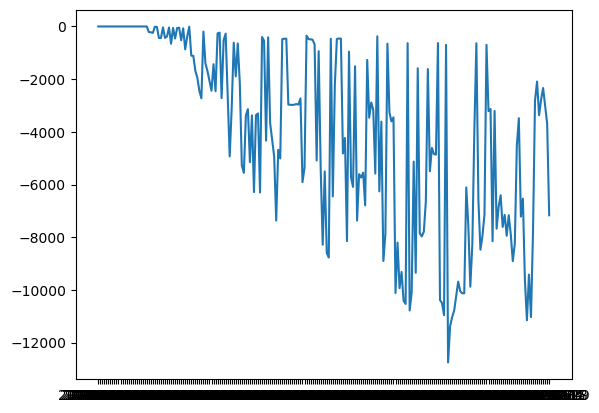

In [102]:
plt.plot(pnl_df['day'], pnl_df['portfolio_value'])
plt.show()

In [97]:
final_day = unique_days[-1]
underlying_final = df[df['quote']==final_day]['underlying'].iloc[0]
underlying_final

5916.98

In [98]:
def final_payoff(instrument, underlying_price):
    if instrument.startswith("kalshi_"):
        # extract bucket
        bucket = instrument.replace("kalshi_", "")
        lower_str, upper_str = bucket.split('-')
        lower, upper = float(lower_str), float(upper_str)
        # If underlying_final is within [lower, upper], payoff = 1, else 0
        return 1.0 if (lower <= underlying_price <= upper) else 0.0
    
    elif instrument.startswith("put_"):
        strike = float(instrument.split('_')[1])
        return max(0, strike - underlying_price)
    
    elif instrument.startswith("call_"):
        strike = float(instrument.split('_')[1])
        return max(0, underlying_price - strike)
    
    else:
        # no known instrument type
        return np.nan
    
final_positions = positions_df.copy()
final_quantities = final_positions.groupby('instrument')['quantity'].sum().reset_index()

final_value = 0.0
for _, rowp in final_quantities.iterrows():
    inst = rowp["instrument"]
    q = rowp["quantity"]
    payoff = final_payoff(inst, underlying_final)
    final_value += q*payoff

print(final_value)

-5394.999999999993


## Checking Hedge Validity

In [ ]:
instruments_of_interest = positions_df['instrument'].unique().tolist()

data